# ScRNA-Seq of human bone marrow cells

Inspired by the work of [Luecken, MD. et al.](https://www.nature.com/articles/s41592-021-01336-8#Sec35)
<br>Code: https://github.com/theislab/scib-reproducibility/tree/main 
<br>
<br>Data from [Oetjen, KA. et al.](https://insight.jci.org/articles/view/124928)
<br>Data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3396161 

In [1]:
# Import packages
import scanpy as sc
import pandas as pd
from functions import data_preprocessing as dp

In [2]:
# Path of data
file_base = '../../../../../data/raw/immune_cells/bone_marrow_human/GSM3396161_A/'
count_file_end = 'GSM3396161_matrix_A.mtx.gz'
gene_data_end = 'GSM3396161_genes_A.tsv.gz'
barcode_data_end = 'GSM3396161_barcodes_A.tsv.gz'

count_data = file_base+count_file_end
gene_data = file_base+gene_data_end
barcode_data = file_base+barcode_data_end

# Read data
adata = dp.read_sc_data(count_data, gene_data, barcode_data)

adata.var_names_make_unique()

In [3]:
print(adata.X.shape)
print(adata)

(2994, 33694)
AnnData object with n_obs × n_vars = 2994 × 33694
    var: 'gene_id'


In [4]:
adata.var.head()

,gene_id
gene_symbol,
RP11-34P13.3,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945


## Preprocessing

In [5]:
# Add QC metrics to adata
adata = dp.QC().QC_metric_calc(adata)
print(adata.obs)

                    n_counts  log_n_counts  n_genes  log_n_genes  \
barcode                                                            
AAACCTGCAAGTAATG-1   10568.0      9.265680      519     6.253829   
AAACCTGCAGCGAACA-1    6379.0      8.760923     1862     7.529943   
AAACCTGCATGTCCTC-1    4172.0      8.336390     1082     6.987490   
AAACCTGGTCGACTGC-1    6608.0      8.796187     1618     7.389564   
AAACCTGGTCGCTTCT-1    5034.0      8.524169     1413     7.254178   
...                      ...           ...      ...          ...   
TTTGGTTGTTAAAGAC-1    3917.0      8.273336      960     6.867974   
TTTGGTTTCCACGCAG-1    3971.0      8.287025     1143     7.042286   
TTTGTCAAGCAAATCA-1    4868.0      8.490644     1062     6.968850   
TTTGTCACAGGGTATG-1    9796.0      9.189832      524     6.263398   
TTTGTCATCAGGCCCA-1    3966.0      8.285766      882     6.783325   

                    pct_counts_in_top_20_genes   mt_frac  
barcode                                                 

In [6]:
qc_adata = dp.QC().QC_filter_outliers(adata,[5,5,5,5])

Number of cells before QC filtering: 2994
Number of cells removed by log_n_genes filtering: 66
Number of cells removed by log_n_counts filtering: 39
Number of cells removed by pct_counts_in_top_20_genes filtering: 620
Number of cells removed by mt_frac filtering: 22
Number of cells post QC filtering: 2311
Number of genes before filtering: 33694
Number of genes after filtering so theres min 20 unique cells per gene: 12438


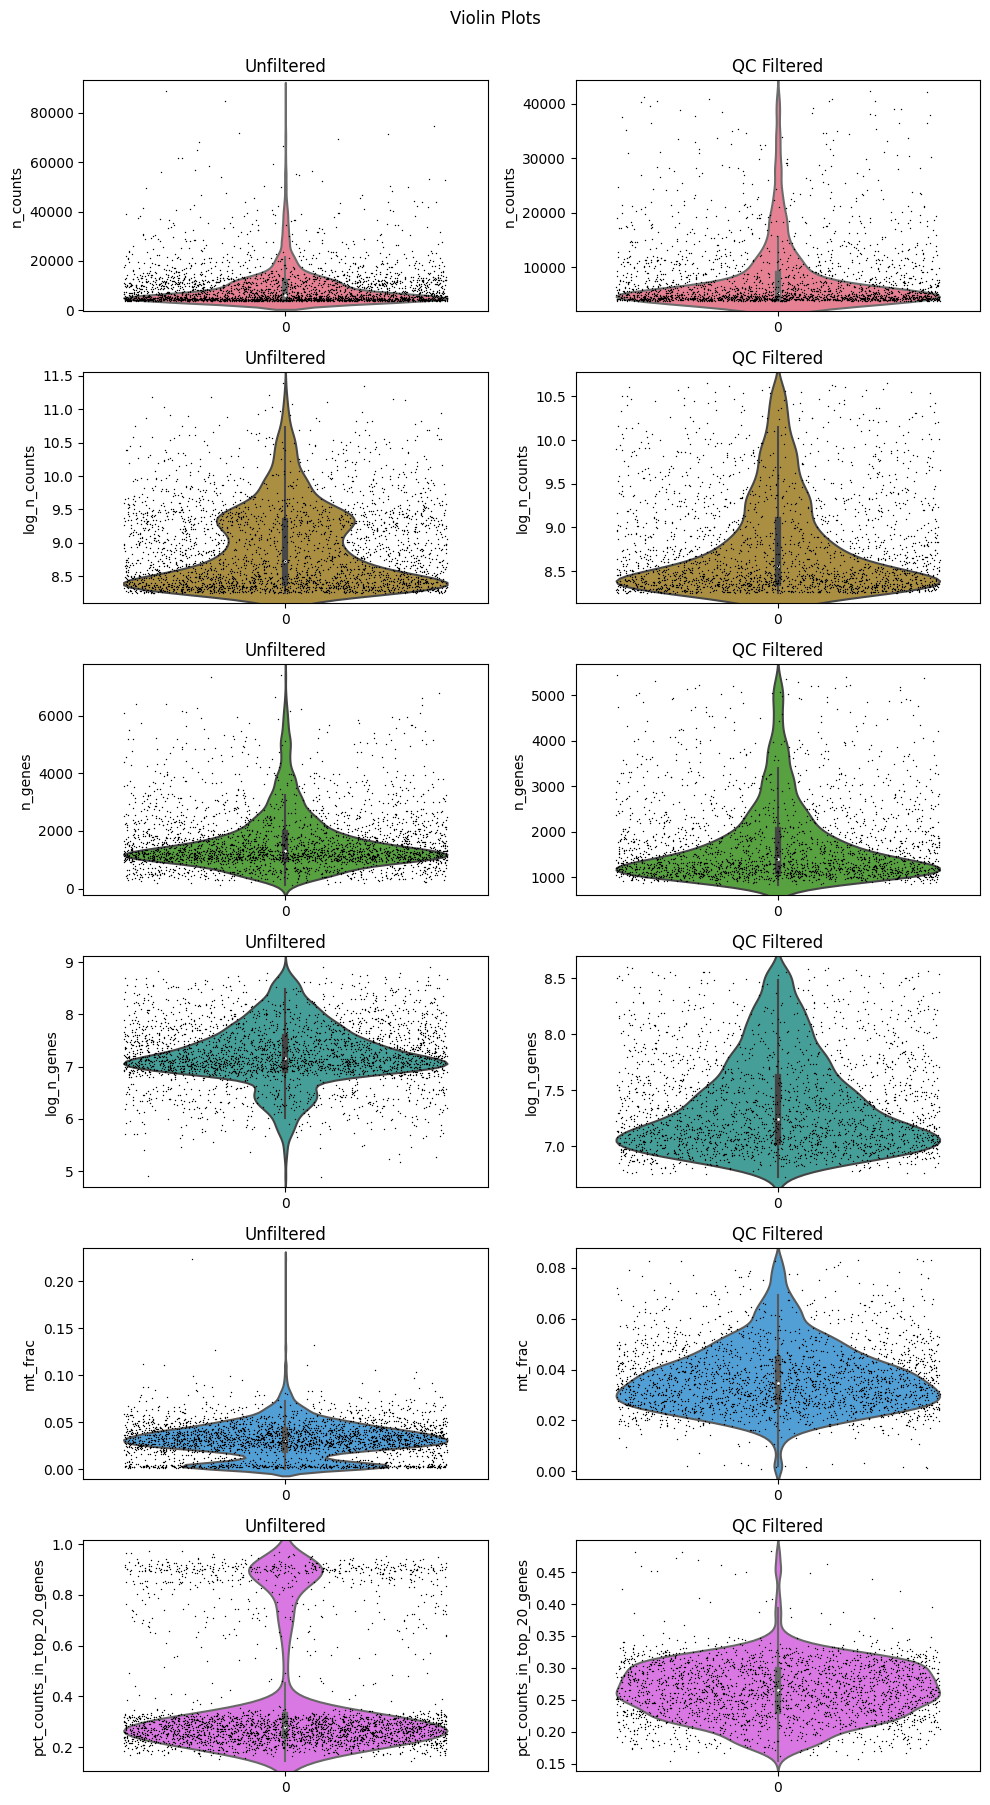

In [7]:
dp.EDA().ViolinJitter([adata, qc_adata], 
                        y_rows=['n_counts','log_n_counts','n_genes','log_n_genes','mt_frac','pct_counts_in_top_20_genes'], 
                        title="Violin Plots",
                        subtitle=["Unfiltered", "QC Filtered"])

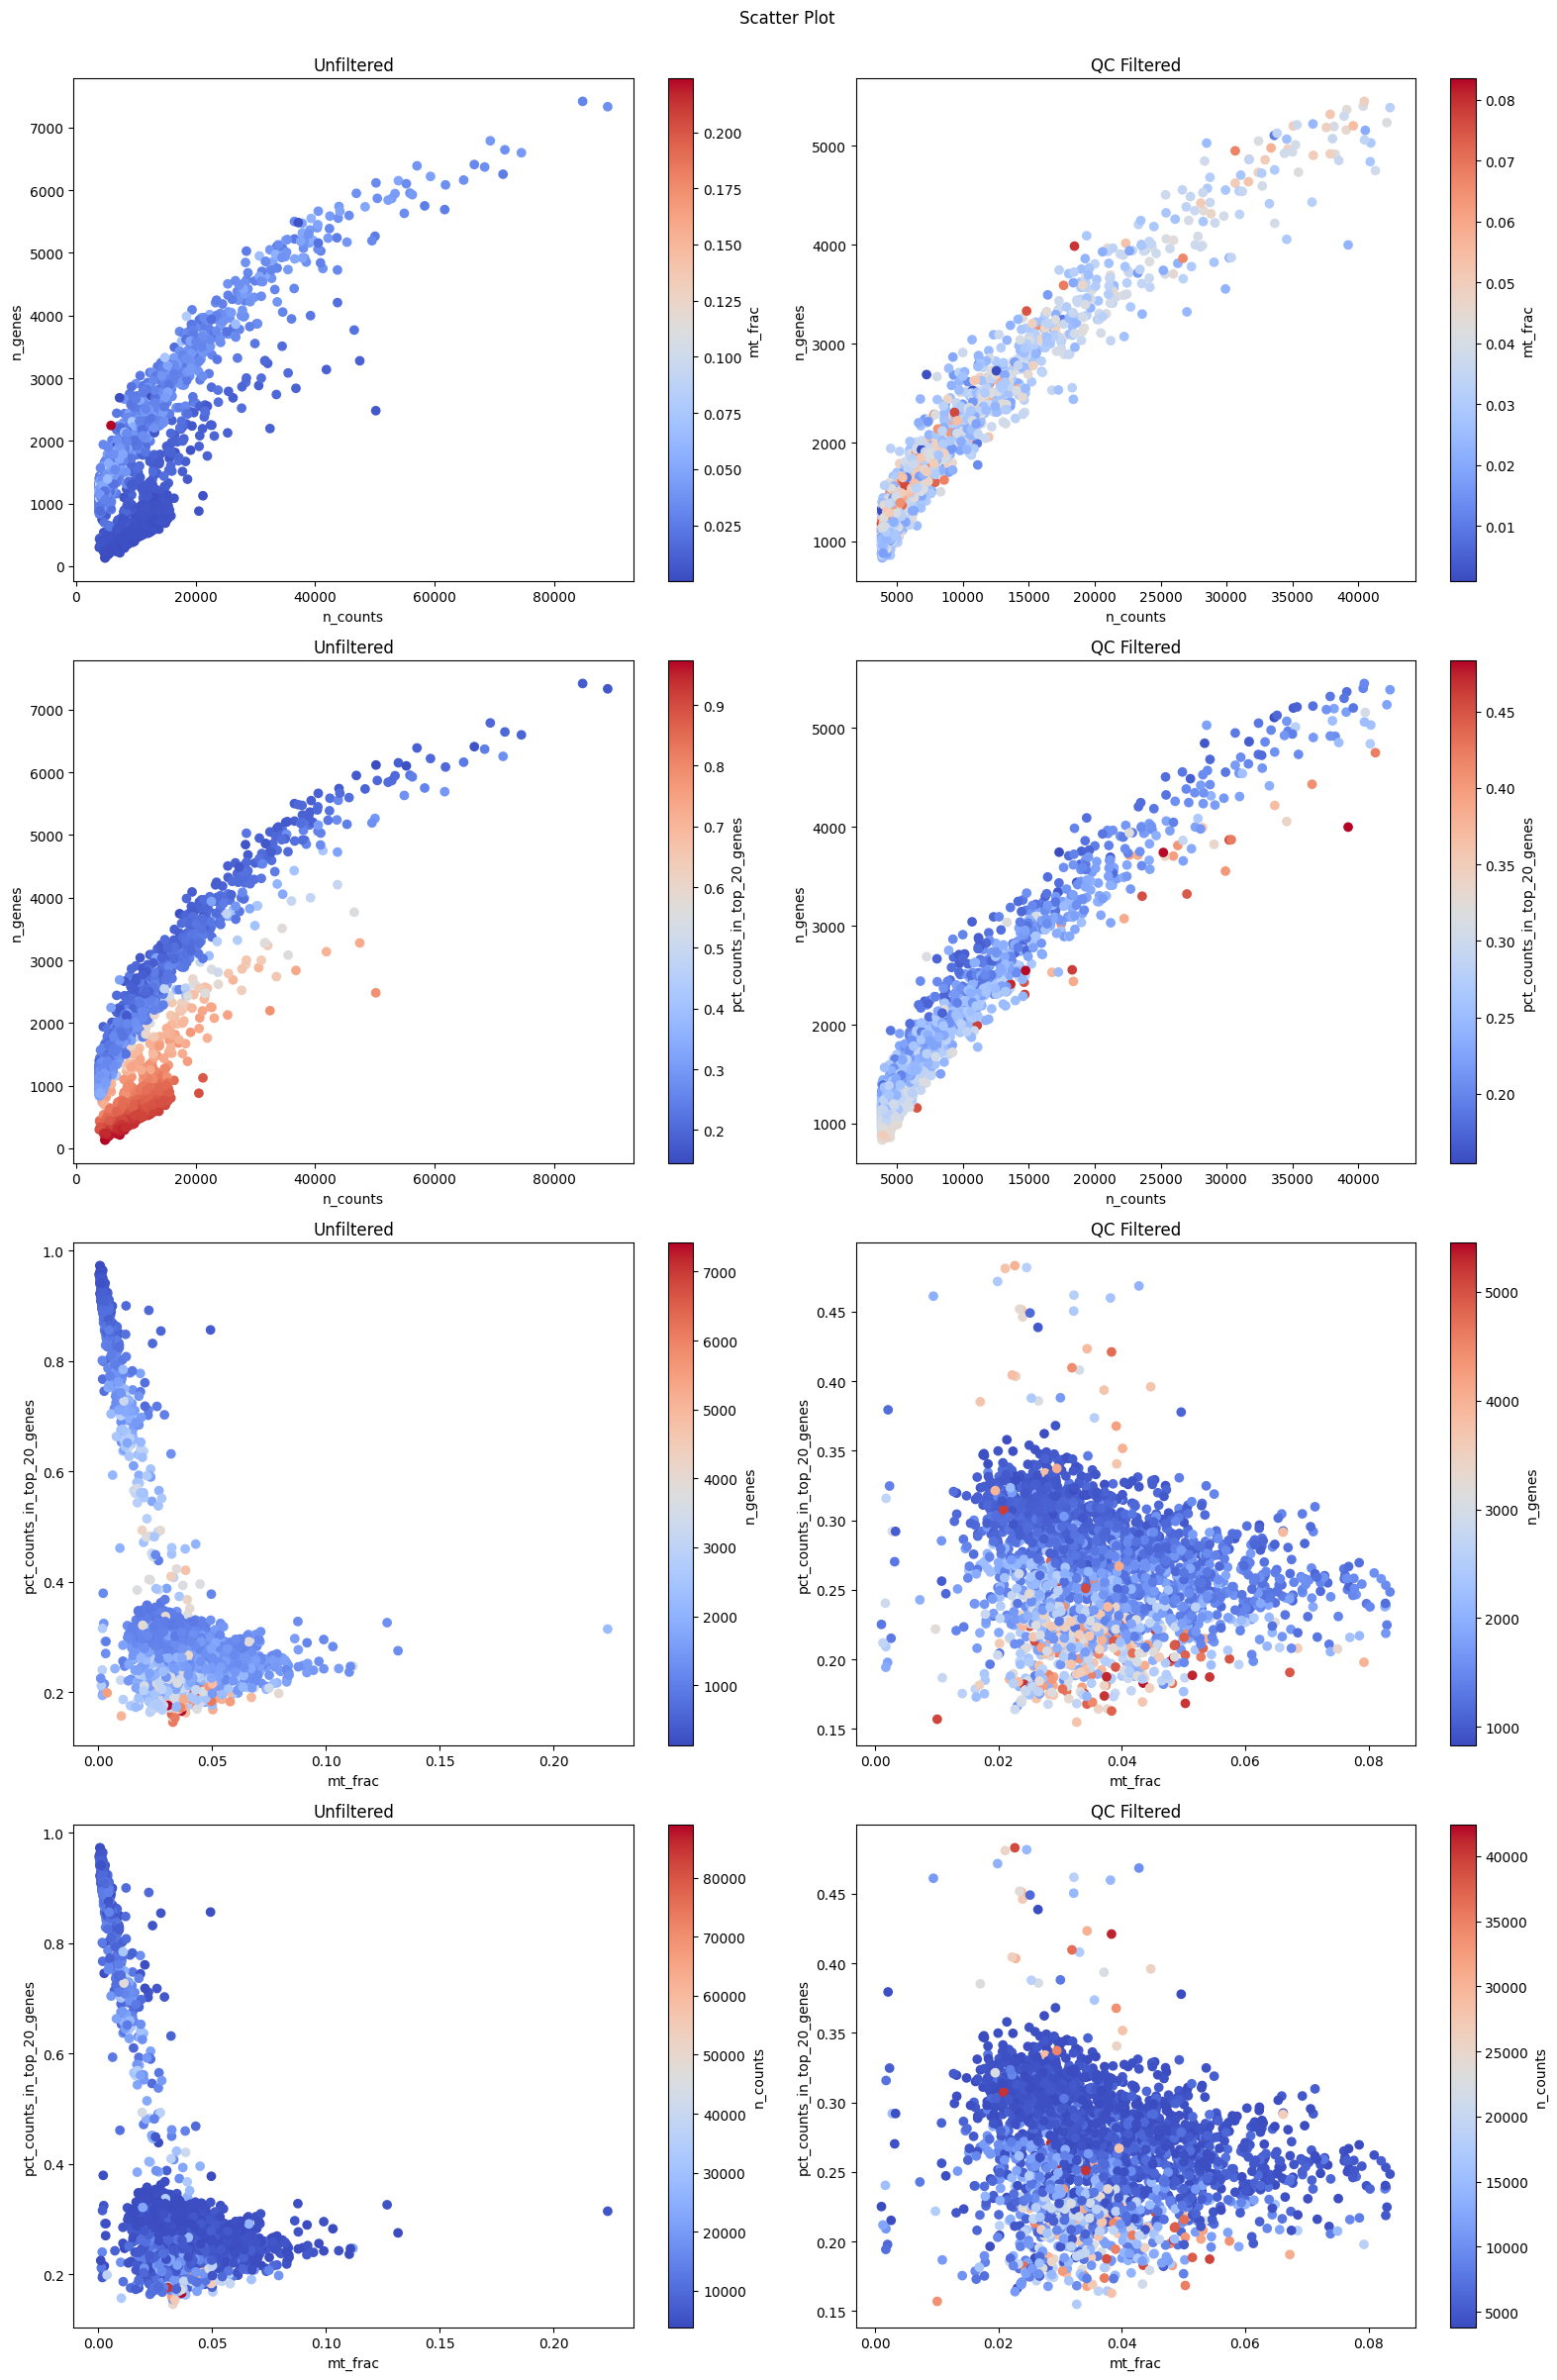

In [8]:
dp.EDA().ScatterForQCMetrics([adata, qc_adata],
                            title="Scatter Plot",
                            subtitle=["Unfiltered", "QC Filtered"])

## Normalize

In [9]:
norm_qc_adata = dp.log1p_normalize(qc_adata)

In [10]:
norm_qc_adata

AnnData object with n_obs × n_vars = 2311 × 12438
    obs: 'n_counts', 'log_n_counts', 'n_genes', 'log_n_genes', 'pct_counts_in_top_20_genes', 'mt_frac', 'outlier', 'size_factors'
    var: 'gene_id', 'n_cells'
    layers: 'pp_counts', 'log1p_counts'

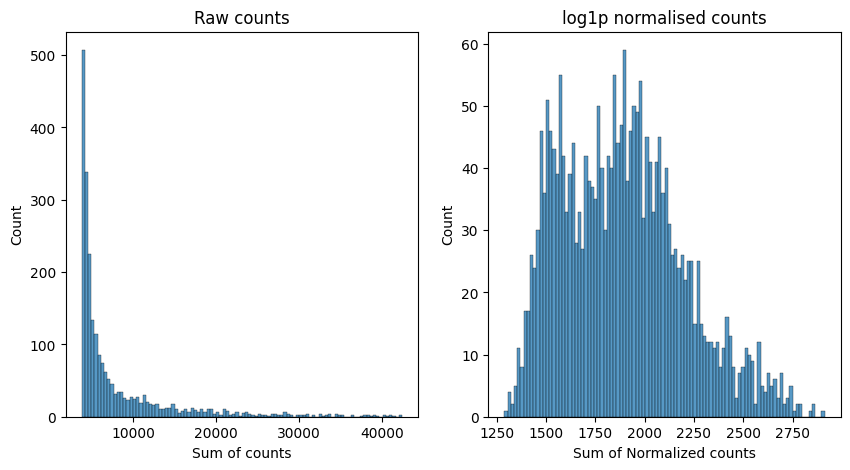

In [11]:
# Visualize counts before and after normalization
dp.EDA().VisualizeNormalization(norm_qc_adata)

In [12]:
# Download normalized count matrix
sc.pp.highly_variable_genes(norm_qc_adata, n_top_genes=4000, flavor="cell_ranger")
HVG_data = norm_qc_adata[:, norm_qc_adata.var["highly_variable"]]
normalized_counts = pd.DataFrame(HVG_data.layers["log1p_counts"])
normalized_counts.index = HVG_data.obs.index.to_list()
normalized_counts.columns = HVG_data.var.index.to_list()
normalized_counts.to_csv("BM_1.csv")
norm_qc_adata.write("BM_1_adata.h5ad")